In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import ExcelWriter
import random
import pickle
from sklearn.model_selection import train_test_split
from scipy.stats import ks_2samp
import random
random.seed(123)

In [2]:
new_df = pd.read_csv('AmountVariables.csv')

In [3]:
## add a dummy variable as for sanity checks
new_df['random'] = np.random.randint(0, 100, new_df.shape[0])

In [ ]:
## calculate ks score for all variables
from scipy.stats import ks_2samp

ks_df = pd.DataFrame()
# ks_df['col'] = list(new_df)[10,:]
ks_df['col'] = list(new_df[new_df.columns[~new_df.columns.isin(['Amount_cn_actual','Amount_mn_actual','Amount_cn_mn_actual','Amount_cn_zip_actual','Amount_cn_st_actual'])]])[10:]

ks_df['p_value'] = ''
ks_df['ks_score'] = ''
for i in range(len(ks_df)):
    ks_df['ks_score'][i] = ks_2samp(new_df[new_df['Fraud'] == 0][ks_df['col'][i]], new_df[new_df['Fraud'] == 1][ks_df['col'][i]])[0]
    ks_df['p_value'][i] = ks_2samp(new_df[new_df['Fraud'] == 0][ks_df['col'][i]], new_df[new_df['Fraud'] == 1][ks_df['col'][i]])[1]


In [ ]:
## calculate fraud detection rate for all variables
def fdr_cal(row):
    col_name = row['col']
    df_temp1 = new_df.sort_values(col_name, ascending = False)
    df_temp_top1 = df_temp1[:round(len(new_df)*0.03)]
    fdr1 = sum(df_temp_top1['Fraud'])/sum(df_temp1['Fraud'])
    df_temp2 = new_df.sort_values(col_name, ascending = True)
    df_temp_top2 = df_temp2[:round(len(new_df)*0.03)]
    fdr2 = sum(df_temp_top2['Fraud'])/sum(df_temp2['Fraud'])
    return max(fdr1, fdr2)

In [ ]:
ks_df['fdr'] = ks_df.apply(lambda row: fdr_cal(row), axis=1)

In [ ]:
## sort variables by fdr
fdr_sorted_list = ks_df.sort_values('fdr', ascending = False)
# fdr_sorted_list.to_pickle('fdr_sorted_list.pkl')

In [ ]:
## sort variables by ks_score
ks_score_sorted_list = ks_df.sort_values('ks_score', ascending = False)
# ks_score_sorted_list.to_pickle('ks_score_sorted_list.pkl')

In [4]:
## Divide into OOT and Train/Test

## Standardizes in-place
def standardize(df, colnames):
    for col in colnames:
        tmp_sd=df[col].std()
        tmp_mean=df[col].mean()
        df[col] = (df[col]-tmp_mean) / tmp_sd
standardize(new_df,list(new_df)[11:])

int_df = new_df[new_df["Date"] < new_df["Date"][84461]] 
oot_df = new_df[new_df["Date"] > new_df["Date"][84288]]

In [ ]:
## calculate ks score for all variables
def fdr_cal(row, df):
    col_name = row['col']
    df_temp = df.sort_values(col_name, ascending = False)
    df_temp_top = df_temp[:round(len(df)*0.03)]
    df_temp_bot = df_temp.tail(round(len(df)*0.03))
    top_fdr= sum(df_temp_top['Fraud'])/sum(df_temp['Fraud'])
    bot_fdr= sum(df_temp_bot['Fraud'])/sum(df_temp['Fraud'])
#     print(str(top_fdr)+ " "+str(bot_fdr))
    return(max(top_fdr, bot_fdr))

def ks_fdr(df):
    ks_df = pd.DataFrame()
    ks_df['col'] = list(df)[10:]
    ks_df['p_value'] = ''
    ks_df['ks_score'] = ''
    # Calc KS
    for i in range(len(ks_df)):
        ks_df['ks_score'][i] = ks_2samp(df[df['Fraud'] == 0][ks_df['col'][i]], df[df['Fraud'] == 1][ks_df['col'][i]])[0]
        ks_df['p_value'][i] = ks_2samp(df[df['Fraud'] == 0][ks_df['col'][i]], df[df['Fraud'] == 1][ks_df['col'][i]])[1]
    # Calc FDR
    ks_df['fdr'] = ks_df.apply(lambda row: fdr_cal(row, df), axis=1)
    return ks_df

In [ ]:
ks_fdr_int = ks_fdr(int_df)
ks_fdr_oot = ks_fdr(oot_df)

In [ ]:
ks_fdr_int['ks_rank'] = ks_fdr_int['ks_score'].rank(ascending = False)
ks_fdr_int['fdr_rank'] = ks_fdr_int['fdr'].rank(ascending = False)
ks_fdr_int['avg_rank'] = ks_fdr_int['ks_rank'] * 0.6 + ks_fdr_int['fdr_rank'] * 0.4

In [ ]:
top_features = ks_fdr_int.sort_values("avg_rank")["col"].head(80)
top_features

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

estimator = LogisticRegression(solver="liblinear", max_iter=300)
selector = RFE(estimator, 20, step=1)
selector = selector.fit(int_df[top_features], int_df["Fraud"])
final_features=top_features[selector.support_]
selected_df = pd.DataFrame(int_df, columns=list(final_features))

selected_df.to_csv("selected_df.csv")

In [5]:
selected_df = pd.read_csv('selected_df.csv')
selected_df = selected_df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
##train, test = train_test_split(selected_df, test_size=0.3)

In [6]:
features = list(selected_df)[1:]

In [7]:
X = selected_df.loc[:, selected_df.columns != 'Fraud']
y = selected_df.loc[:, selected_df.columns == 'Fraud']
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['Fraud'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['Fraud']==0]))
print("Number of subscription",len(os_data_y[os_data_y['Fraud']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['Fraud']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['Fraud']==1])/len(os_data_X))

/Users/Yao.Lu@ibm.com/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


length of oversampled data is  116998
Number of no subscription in oversampled data 58499
Number of subscription 58499
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


In [ ]:
import statsmodels.api as sm
logit_model=sm.Logit(os_data_y,os_data_X)
result=logit_model.fit()
print(result.summary2())

In [8]:
selected_features = ['Amount_cn_st_actual',
 'Amount_mn_30d_act-avg',
 'Amount_cn_14d_act-avg',
 'Amount_cn_7d_act-avg',
 'Amount_cn_st_7d_sum',
 'Amount_cn_st_4d_avg',
 'Amount_cn_14d_sum',
 'Amount_cn_st_30d_act-avg',
 'Amount_cn_st_7d_avg',
 'Amount_mn_30d_act/avg',
 'Amount_cn_30d_act/avg',
 'Amount_cn_mn_7d_sum',
 'Amount_cn_30d_sum',
 'Amount_cn_30d_act/sum',
 'Amount_cn_zip_30d_avg',
 'Amount_cn_zip_30d_sum',
 'Amount_cn_st_7d_act-avg',
 'Amount_mn_1d_avg']

In [9]:
X=os_data_X[selected_features]
y=os_data_y['Fraud']

In [ ]:
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(X, y)

/Users/Yao.Lu@ibm.com/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [15]:
y_pred = logreg.predict(X_test[selected_features])
sum(y_pred == y_test['Fraud'])/len(X_test)

0.949398065916716

In [16]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test[selected_features], y_test['Fraud'])))

Accuracy of logistic regression classifier on test set: 0.95


In [17]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     25068
           1       0.15      0.85      0.26       267

   micro avg       0.95      0.95      0.95     25335
   macro avg       0.58      0.90      0.62     25335
weighted avg       0.99      0.95      0.97     25335



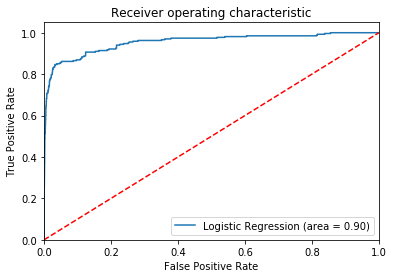

In [18]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test[selected_features]))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test[selected_features])[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [19]:
logit_roc_auc

0.9021737279095242

In [20]:
X = oot_df.loc[:, selected_features]
y = oot_df.loc[:, oot_df.columns == 'Fraud']
y_pred = logreg.predict(X[selected_features])
sum(y_pred == oot_df['Fraud'])/len(oot_df)

0.9508937340404635

In [21]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y, y_pred)
print(confusion_matrix)

[[9563  444]
 [  56  119]]


In [22]:
from sklearn.metrics import classification_report
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97     10007
           1       0.21      0.68      0.32       175

   micro avg       0.95      0.95      0.95     10182
   macro avg       0.60      0.82      0.65     10182
weighted avg       0.98      0.95      0.96     10182



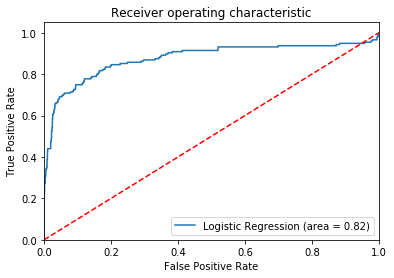

In [23]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y, logreg.predict(X[selected_features]))
fpr, tpr, thresholds = roc_curve(y, logreg.predict_proba(X[selected_features])[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

results without oversampling

In [ ]:
X=X_train[selected_features]
y=y_train['Fraud']
logreg2 = LogisticRegression()
logreg2.fit(X, y)

In [ ]:
y_pred = logreg2.predict(X_test[selected_features])
sum(y_pred == y_test['Fraud'])/len(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg2.predict(X_test[selected_features]))
fpr, tpr, thresholds = roc_curve(y_test, logreg2.predict_proba(X_test[selected_features])[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
##plt.savefig('Log_ROC')
plt.show()

In [ ]:
logit_roc_auc

In [ ]:
X=os_data_X[features]
y=os_data_y['Fraud']

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(13,13,13),max_iter=500)
mlp.fit(X,y)

In [ ]:
predictions = mlp.predict(X_test[features])

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test,predictions))

In [ ]:
35*1000 + 361*20

In [ ]:
print(classification_report(y_test,predictions))

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, predictions)
fpr, tpr, thresholds = roc_curve(y_test, mlp.predict_proba(X_test[features])[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
##plt.savefig('Log_ROC')
plt.show()

In [ ]:
mlp.predict_proba(X_test[features])

In [ ]:
logit_roc_auc

In [ ]:
X = oot_df.loc[:, features]
y = oot_df.loc[:, oot_df.columns == 'Fraud']
y_pred = mlp.predict(X[features])
sum(y_pred == oot_df['Fraud'])/len(oot_df)

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y,y_pred))

In [ ]:
print(classification_report(y,y_pred))

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y, y_pred)
fpr, tpr, thresholds = roc_curve(y, mlp.predict_proba(X[features])[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
##plt.savefig('Log_ROC')
plt.show()